In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import files
uploaded = files.upload()


Saving kaggle.json to kaggle.json


In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
 ! kaggle datasets download -d adityajn105/flickr8k

100% 1.03G/1.04G [00:36<00:00, 31.9MB/s]
100% 1.04G/1.04G [00:36<00:00, 30.7MB/s]


In [ ]:
! mkdir train
! unzip flickr8k.zip -d train

In [ ]:
#location of the training data
data_location =  "/content/train"
#imports
import numpy as np
import torch
from torch.utils.data import DataLoader,Dataset
import torchvision.transforms as T

In [ ]:
#reading the text data
import pandas as pd
caption_file = data_location + '/captions.txt'
df = pd.read_csv(caption_file)
print("There are {} image to captions".format(len(df)))
df.head(7)

There are 40455 image to captions


,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...
5,1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting
6,1001773457_577c3a7d70.jpg,A black dog and a tri-colored dog playing with...


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

#select any index from the whole dataset
#single image has 5 captions
#so, select indx as: 1,6,11,16...
data_idx = 11

image_path = data_location+"/Images/"+df.iloc[data_idx,0]
img=mpimg.imread(image_path)
plt.imshow(img)
plt.show()

#image consits of 5 captions,
#showing all 5 captions of the image of the given idx
for i in range(data_idx,data_idx+5):
    print("Caption:",df.iloc[i,1])

In [ ]:
#imports
import os
from collections import Counter
import spacy
import torch
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader,Dataset
import torchvision.transforms as T

from PIL import Image

In [ ]:
#using spacy for the better text tokenization
spacy_eng = spacy.load("en_core_web_sm")

#example
text = "This is a good place to find a city"
[token.text.lower() for token in spacy_eng.tokenizer(text)]

['this', 'is', 'a', 'good', 'place', 'to', 'find', 'a', 'city']

In [ ]:
class Vocabulary:
    def __init__(self,freq_threshold):
        #setting the pre-reserved tokens int to string tokens
        self.itos = {0:"<PAD>",1:"<SOS>",2:"<EOS>",3:"<UNK>"}

        #string to int tokens
        #its reverse dict self.itos
        self.stoi = {v:k for k,v in self.itos.items()}

        self.freq_threshold = freq_threshold

    def __len__(self): return len(self.itos)

    @staticmethod
    def tokenize(text):
        return [token.text.lower() for token in spacy_eng.tokenizer(text)]

    def build_vocab(self, sentence_list):
        frequencies = Counter()
        idx = 4
        for sentence in sentence_list:
            for word in self.tokenize(sentence):
                frequencies[word] += 1

                #add the word to the vocab if it reaches minum frequecy threshold
                if frequencies[word] == self.freq_threshold:
                    self.stoi[word] = idx
                    self.itos[idx] = word
                    idx += 1

    def numericalize(self,text):
        """ For each word in the text corresponding index token for that word form the vocab built as list """
        tokenized_text = self.tokenize(text)
        return [ self.stoi[token] if token in self.stoi else self.stoi["<UNK>"] for token in tokenized_text ]

In [ ]:
class FlickrDataset(Dataset):
    """
    FlickrDataset
    """
    def __init__(self,root_dir,captions_file,transform=None,freq_threshold=5):
        self.root_dir = root_dir
        self.df = pd.read_csv(caption_file)
        self.transform = transform

        #Get image and caption colum from the dataframe
        self.imgs = self.df["image"]
        self.captions = self.df["caption"]

        #Initialize vocabulary and build vocab
        self.vocab = Vocabulary(freq_threshold)
        self.vocab.build_vocab(self.captions.tolist())


    def __len__(self):
        return len(self.df)

    def __getitem__(self,idx):
        caption = self.captions[idx]
        img_name = self.imgs[idx]
        img_location = os.path.join(self.root_dir,img_name)
        img = Image.open(img_location).convert("RGB")

        #apply the transfromation to the image
        if self.transform is not None:
            img = self.transform(img)

        #numericalize the caption text
        caption_vec = []
        caption_vec += [self.vocab.stoi["<SOS>"]]
        caption_vec += self.vocab.numericalize(caption)
        caption_vec += [self.vocab.stoi["<EOS>"]]

        return img, torch.tensor(caption_vec)

In [ ]:
#defing the transform to be applied
transforms = T.Compose([
    T.Resize((224,224)),
    T.ToTensor()
])

In [ ]:
def show_image(inp, title=None, bleu=None, reference=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    if reference is not None:
        plt.xlabel(reference)
    if bleu is not None:
        sub = "Bleu score: {:.2f}".format(bleu)
        plt.suptitle(sub)
    plt.pause(0.001)  # pause a bit so that plots are updated

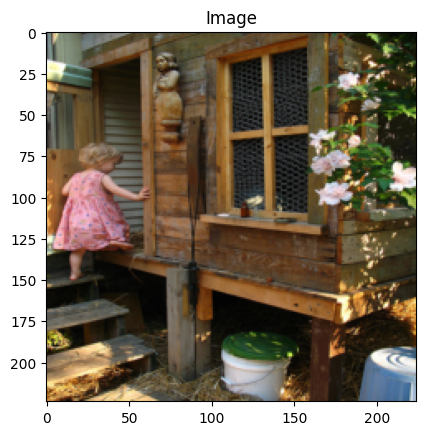

Token: tensor([  1,   4,  28,   8,   4, 195, 151,  17,  32,  67,   4, 353,  11, 711,
          8,  24,   3, 496,   5,   2])
Sentence:
['<SOS>', 'a', 'child', 'in', 'a', 'pink', 'dress', 'is', 'climbing', 'up', 'a', 'set', 'of', 'stairs', 'in', 'an', '<UNK>', 'way', '.', '<EOS>']


In [ ]:
#testing the dataset class
dataset =  FlickrDataset(
    root_dir = data_location+"/Images",
    captions_file = data_location+"/captions.txt",
    transform=transforms
)

img, caps = dataset[0]
show_image(img,"Image")
print("Token:",caps)
print("Sentence:")
print([dataset.vocab.itos[token] for token in caps.tolist()])

In [ ]:
class CapsCollate:
    """
    Collate to apply the padding to the captions with dataloader
    """
    def __init__(self,pad_idx,batch_first=False):
        self.pad_idx = pad_idx
        self.batch_first = batch_first

    def __call__(self,batch):
        imgs = [item[0].unsqueeze(0) for item in batch]
        imgs = torch.cat(imgs,dim=0)

        targets = [item[1] for item in batch]
        targets = pad_sequence(targets, batch_first=self.batch_first, padding_value=self.pad_idx)
        return imgs,targets

In [ ]:
#writing the dataloader
#setting the constants
BATCH_SIZE = 4
NUM_WORKER = 1

#token to represent the padding
pad_idx = dataset.vocab.stoi["<PAD>"]

data_loader = DataLoader(
    dataset=dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKER,
    shuffle=True,
    collate_fn=CapsCollate(pad_idx=pad_idx,batch_first=True)
)

In [ ]:
#generating the iterator from the dataloader
dataiter = iter(data_loader)

#getting the next batch
batch = next(dataiter)

#unpacking the batch
images, captions = batch

#showing info of image in single batch
for i in range(BATCH_SIZE):
    img,cap = images[i],captions[i]
    caption_label = [dataset.vocab.itos[token] for token in cap.tolist()]
    eos_index = caption_label.index('<EOS>')
    caption_label = caption_label[1:eos_index]
    caption_label = ' '.join(caption_label)
    show_image(img,caption_label)
    plt.show()

### 2) **<b>Implementing the Helper function to plot the Tensor image**

In [ ]:
#show the tensor image
import matplotlib.pyplot as plt
def show_image(img, title=None):
    """Imshow for Tensor."""

    #unnormalize
    img[0] = img[0] * 0.229
    img[1] = img[1] * 0.224
    img[2] = img[2] * 0.225
    img[0] += 0.485
    img[1] += 0.456
    img[2] += 0.406

    img = img.numpy().transpose((1, 2, 0))

    plt.imshow(img)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [112]:
#Initiate the Dataset and Dataloader

#setting the constants
data_location =  "/content/train"
BATCH_SIZE = 256
# BATCH_SIZE = 6
NUM_WORKER = 4

#defining the transform to be applied
transforms = T.Compose([
    T.Resize(226),
    T.RandomCrop(224),
    T.ToTensor(),
    T.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
])

#vocab_size
vocab_size = len(dataset.vocab)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

### 3) Defining the Model Architecture

In [153]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision.models as models
from torch.utils.data import DataLoader,Dataset
import torchvision.transforms as T

In [154]:
class EncoderCNN(nn.Module):
    def __init__(self):
        super(EncoderCNN, self).__init__()
        resnet = models.resnet50(pretrained=True)
        for param in resnet.parameters():
            param.requires_grad_(False)

        modules = list(resnet.children())[:-2]
        self.resnet = nn.Sequential(*modules)


    def forward(self, images):
        features = self.resnet(images)                                    #(batch_size,2048,7,7)
        features = features.permute(0, 2, 3, 1)                           #(batch_size,7,7,2048)
        features = features.view(features.size(0), -1, features.size(-1)) #(batch_size,49,2048)
        return features

In [155]:
class DecoderRNN(nn.Module):
    def __init__(self, embed_size, vocab_size, encoder_dim, decoder_dim, drop_prob=0.3):
        super().__init__()

        # Save model parameters
        self.vocab_size = vocab_size
        self.decoder_dim = decoder_dim

        self.embedding = nn.Embedding(vocab_size, embed_size)

        self.init_h = nn.Linear(encoder_dim, decoder_dim)
        self.init_c = nn.Linear(encoder_dim, decoder_dim)

        self.lstm_cell = nn.LSTMCell(embed_size, decoder_dim, bias=True)

        self.fcn = nn.Linear(decoder_dim, vocab_size)
        self.drop = nn.Dropout(drop_prob)

    def forward(self, features, captions):
        # Vectorize the captions
        embeds = self.embedding(captions)

        # Initialize LSTM state
        h, c = self.init_hidden_state(features)  # (batch_size, decoder_dim)

        # Get the sequence length to iterate
        seq_length = len(captions[0]) - 1  # Exclude the last one
        batch_size = captions.size(0)

        preds = torch.zeros(batch_size, seq_length, self.vocab_size).to(device)

        for s in range(seq_length):
            lstm_input = embeds[:, s]
            h, c = self.lstm_cell(lstm_input, (h, c))

            output = self.fcn(self.drop(h))

            preds[:, s] = output

        return preds

    def generate_caption(self, features, max_len=20, vocab=None):
        # Inference part
        # Given the image features generate the captions

        batch_size = features.size(0)
        h, c = self.init_hidden_state(features)  # (batch_size, decoder_dim)

        # Starting input
        word = torch.tensor(vocab.stoi['<SOS>']).view(1, -1).to(device)
        embeds = self.embedding(word)

        captions = []

        for i in range(max_len):
            h, c = self.lstm_cell(embeds[:, 0], (h, c))
            output = self.fcn(self.drop(h))
            output = output.view(batch_size, -1)

            # Select the word with the highest value
            predicted_word_idx = output.argmax(dim=1)

            # Save the generated word
            captions.append(predicted_word_idx.item())

            # End if <EOS> detected
            if vocab.itos[predicted_word_idx.item()] == "<EOS>":
                break

            # Send generated word as the next caption
            embeds = self.embedding(predicted_word_idx.unsqueeze(0))

        # Convert the vocab idx to words and return the sentence
        return [vocab.itos[idx] for idx in captions]

    def init_hidden_state(self, features):
        mean_features = features.mean(dim=1)
        h = self.init_h(mean_features)
        c = self.init_c(mean_features)
        return h, c


In [156]:
class EncoderDecoder(nn.Module):
    def __init__(self,embed_size, vocab_size,encoder_dim,decoder_dim,drop_prob=0.3):
        super().__init__()
        self.encoder = EncoderCNN()
        self.decoder = DecoderRNN(
            embed_size=embed_size,
            vocab_size = len(dataset.vocab),
            encoder_dim=encoder_dim,
            decoder_dim=decoder_dim
        )

    def forward(self, images, captions):
        features = self.encoder(images)
        outputs = self.decoder(features, captions)
        return outputs


### 4) Defining the Model Architecture with Attention

Model is seq2seq model. In the **encoder** pretrained ResNet model is used to extract the features. Decoder, is the implementation of the Bahdanau Attention Decoder. In the decoder model **LSTM cell**.

In [ ]:
class EncoderCNN(nn.Module):
    def __init__(self):
        super(EncoderCNN, self).__init__()
        resnet = models.resnet50(pretrained=True)
        for param in resnet.parameters():
            param.requires_grad_(False)

        modules = list(resnet.children())[:-2]
        self.resnet = nn.Sequential(*modules)


    def forward(self, images):
        features = self.resnet(images)                                    #(batch_size,2048,7,7)
        features = features.permute(0, 2, 3, 1)                           #(batch_size,7,7,2048)
        features = features.view(features.size(0), -1, features.size(-1)) #(batch_size,49,2048)
        return features


In [ ]:
#Bahdanau Attention
class Attention(nn.Module):
    def __init__(self, encoder_dim,decoder_dim,attention_dim):
        super(Attention, self).__init__()

        self.attention_dim = attention_dim

        self.W = nn.Linear(decoder_dim,attention_dim)
        self.U = nn.Linear(encoder_dim,attention_dim)

        self.A = nn.Linear(attention_dim,1)




    def forward(self, features, hidden_state):
        u_hs = self.U(features)     #(batch_size,num_layers,attention_dim)
        w_ah = self.W(hidden_state) #(batch_size,attention_dim)

        combined_states = torch.tanh(u_hs + w_ah.unsqueeze(1)) #(batch_size,num_layers,attemtion_dim)

        attention_scores = self.A(combined_states)         #(batch_size,num_layers,1)
        attention_scores = attention_scores.squeeze(2)     #(batch_size,num_layers)


        alpha = F.softmax(attention_scores,dim=1)          #(batch_size,num_layers)

        attention_weights = features * alpha.unsqueeze(2)  #(batch_size,num_layers,features_dim)
        attention_weights = attention_weights.sum(dim=1)   #(batch_size,num_layers)

        return alpha,attention_weights


In [ ]:
#Attention Decoder
class DecoderRNN(nn.Module):
    def __init__(self,embed_size, vocab_size, attention_dim,encoder_dim,decoder_dim,drop_prob=0.3):
        super().__init__()

        #save the model param
        self.vocab_size = vocab_size
        self.attention_dim = attention_dim
        self.decoder_dim = decoder_dim

        self.embedding = nn.Embedding(vocab_size,embed_size)
        self.attention = Attention(encoder_dim,decoder_dim,attention_dim)


        self.init_h = nn.Linear(encoder_dim, decoder_dim)
        self.init_c = nn.Linear(encoder_dim, decoder_dim)
        self.lstm_cell = nn.LSTMCell(embed_size+encoder_dim,decoder_dim,bias=True)
        self.f_beta = nn.Linear(decoder_dim, encoder_dim)


        self.fcn = nn.Linear(decoder_dim,vocab_size)
        self.drop = nn.Dropout(drop_prob)



    def forward(self, features, captions):

        #vectorize the caption
        embeds = self.embedding(captions)

        # Initialize LSTM state
        h, c = self.init_hidden_state(features)  # (batch_size, decoder_dim)

        #get the seq length to iterate
        seq_length = len(captions[0])-1 #Exclude the last one
        batch_size = captions.size(0)
        num_features = features.size(1)

        preds = torch.zeros(batch_size, seq_length, self.vocab_size).to(device)
        alphas = torch.zeros(batch_size, seq_length,num_features).to(device)

        for s in range(seq_length):
            alpha,context = self.attention(features, h)
            lstm_input = torch.cat((embeds[:, s], context), dim=1)
            h, c = self.lstm_cell(lstm_input, (h, c))

            output = self.fcn(self.drop(h))

            preds[:,s] = output
            alphas[:,s] = alpha


        return preds, alphas

    def generate_caption(self,features,max_len=20,vocab=None):
        # Inference part
        # Given the image features generate the captions

        batch_size = features.size(0)
        h, c = self.init_hidden_state(features)  # (batch_size, decoder_dim)

        alphas = []

        #starting input
        word = torch.tensor(vocab.stoi['<SOS>']).view(1,-1).to(device)
        embeds = self.embedding(word)


        captions = []

        for i in range(max_len):
            alpha,context = self.attention(features, h)


            #store the apla score
            alphas.append(alpha.cpu().detach().numpy())

            lstm_input = torch.cat((embeds[:, 0], context), dim=1)
            h, c = self.lstm_cell(lstm_input, (h, c))
            output = self.fcn(self.drop(h))
            output = output.view(batch_size,-1)


            #select the word with most val
            predicted_word_idx = output.argmax(dim=1)

            #save the generated word
            captions.append(predicted_word_idx.item())

            #end if <EOS detected>
            if vocab.itos[predicted_word_idx.item()] == "<EOS>":
                break

            #send generated word as the next caption
            embeds = self.embedding(predicted_word_idx.unsqueeze(0))

        #covert the vocab idx to words and return sentence
        return [vocab.itos[idx] for idx in captions],alphas


    def init_hidden_state(self, encoder_out):
        mean_encoder_out = encoder_out.mean(dim=1)
        h = self.init_h(mean_encoder_out)  # (batch_size, decoder_dim)
        c = self.init_c(mean_encoder_out)
        return h, c


In [ ]:
class EncoderDecoder(nn.Module):
    def __init__(self,embed_size, vocab_size, attention_dim,encoder_dim,decoder_dim,drop_prob=0.3):
        super().__init__()
        self.encoder = EncoderCNN()
        self.decoder = DecoderRNN(
            embed_size=embed_size,
            vocab_size = len(dataset.vocab),
            attention_dim=attention_dim,
            encoder_dim=encoder_dim,
            decoder_dim=decoder_dim
        )

    def forward(self, images, captions):
        features = self.encoder(images)
        outputs = self.decoder(features, captions)
        return outputs


## 5) Hyparameter model for training

In [157]:
embed_size=300
vocab_size = len(dataset.vocab)
attention_dim=256
encoder_dim=2048
decoder_dim=512
learning_rate = 3e-4

### no attention

In [158]:
#init model
model = EncoderDecoder(
    embed_size=300,
    vocab_size = len(dataset.vocab),
    encoder_dim=2048,
    decoder_dim=512
).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=dataset.vocab.stoi["<PAD>"])
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [159]:
import torch
import torch.nn as nn
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

checkpoint = torch.load('/content/drive/MyDrive/DeepLearning/midtern/model_state.pth')

num_epochs = checkpoint['num_epochs']
embed_size = checkpoint['embed_size']
vocab_size = checkpoint['vocab_size']
encoder_dim = checkpoint['encoder_dim']
decoder_dim = checkpoint['decoder_dim']

model = EncoderDecoder(embed_size, vocab_size, encoder_dim, decoder_dim)

model.load_state_dict(checkpoint['state_dict'])
model.to(device)

model.eval()


EncoderDecoder(
  (encoder): EncoderCNN(
    (resnet): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
 

In [160]:

#helper function to save the model
def save_model(model,num_epochs):
    model_state = {
        'num_epochs':num_epochs,
        'embed_size':embed_size,
        'vocab_size':len(dataset.vocab),
        'encoder_dim':encoder_dim,
        'decoder_dim':decoder_dim,
        'state_dict':model.state_dict()
    }

    torch.save(model_state,'model_state.pth')

### attention

In [113]:
#init model
model = EncoderDecoder(
    embed_size=300,
    vocab_size = len(dataset.vocab),
    encoder_dim=2048,
    attention_dim=256,
    decoder_dim=512
).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=dataset.vocab.stoi["<PAD>"])
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [114]:
import torch
import torch.nn as nn
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

checkpoint = torch.load('/content/drive/MyDrive/DeepLearning/midtern/attention.pth')

num_epochs = checkpoint['num_epochs']
embed_size = checkpoint['embed_size']
vocab_size = checkpoint['vocab_size']
attention_dim = checkpoint['attention_dim']
encoder_dim = checkpoint['encoder_dim']
decoder_dim = checkpoint['decoder_dim']

model = EncoderDecoder(embed_size, vocab_size, attention_dim, encoder_dim, decoder_dim)

model.load_state_dict(checkpoint['state_dict'])
model.to(device)

model.eval()


EncoderDecoder(
  (encoder): EncoderCNN(
    (resnet): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
 

In [ ]:

#helper function to save the model
def save_model_attention(model,num_epochs):
    model_state = {
        'num_epochs':num_epochs,
        'embed_size':embed_size,
        'vocab_size':len(dataset.vocab),
        'attention_dim':attention_dim,
        'encoder_dim':encoder_dim,
        'decoder_dim':decoder_dim,
        'state_dict':model.state_dict()
    }

    torch.save(model_state,'/content/drive/MyDrive/DeepLearning/attention_model_state.pth')

## 6) Training Job from above configs

### no attention

In [ ]:
num_epochs = 5
print_every = 400

for epoch in range(1,num_epochs+1):
    print("Epoch: {} training".format(epoch))
    for idx, (image, captions) in enumerate(iter(data_loader)):
        image,captions = image.to(device),captions.to(device)

        # Zero the gradients.
        optimizer.zero_grad()

        # Feed forward
        outputs = model(image, captions)

        # Calculate the batch loss.
        targets = captions[:,1:]
        loss = criterion(outputs.view(-1, vocab_size), targets.reshape(-1))

        # Backward pass.
        loss.backward()

        # Update the parameters in the optimizer.
        optimizer.step()

        # if (idx+1)%print_every == 0:
        #     #generate the caption
        #     model.eval()
        #     with torch.no_grad():
        #         dataiter = iter(data_loader)
        #         img,_ = next(dataiter)
        #         features = model.encoder(img[0:1].to(device))
        #         caps,alphas = model.decoder.generate_caption(features,vocab=dataset.vocab)
        #         caption = ' '.join(caps)
        #         show_image(img[0],title=caption)

        #     model.train()
    print("Loss: {:.5f} for epochs".format(loss.item()))

    #save the latest model
    save_model(model,epoch)

Epoch: 1 training
Loss: 1.85279 for epochs
Epoch: 2 training
Loss: 2.21923 for epochs
Epoch: 3 training
Loss: 2.26414 for epochs
Epoch: 4 training
Loss: 1.93359 for epochs
Epoch: 5 training
Loss: 2.06524 for epochs


### attention

In [ ]:
num_epochs =15
print_every = 100

for epoch in range(1,num_epochs+1):
    print("Epoch: {} training".format(epoch))
    for idx, (image, captions) in enumerate(iter(data_loader)):
        image,captions = image.to(device),captions.to(device)

        # Zero the gradients.
        optimizer.zero_grad()

        # Feed forward
        outputs,attentions = model(image, captions)

        # Calculate the batch loss.
        targets = captions[:,1:]
        loss = criterion(outputs.view(-1, vocab_size), targets.reshape(-1))

        # Backward pass.
        loss.backward()

        # Update the parameters in the optimizer.
        optimizer.step()

        if (idx+1)%print_every == 0:
            #generate the caption
            model.eval()
            with torch.no_grad():
                dataiter = iter(data_loader)
                img,_ = next(dataiter)
                features = model.encoder(img[0:1].to(device))
                caps,alphas = model.decoder.generate_caption(features,vocab=dataset.vocab)
                caption = ' '.join(caps)
                show_image(img[0],title=caption)

            model.train()
    print("Loss: {:.5f} for epochs".format(loss.item()))

    #save the latest model
    save_model_attention(model,epoch)

## 7) Visualizing the model not attention

In [163]:
# get bleu score of image
def get_bleu_score(candidate, reference):
    reference = reference.split()
    candidate = candidate.split()
    # weights = (0.25, 0.25, 0.25, 0.25)
    weights = (1,0,0,0)
    smoothing = SmoothingFunction().method4
    bleu_score = sentence_bleu(reference, candidate, weights=weights, smoothing_function=smoothing)
    return bleu_score
#generate caption
def get_caps_from(features_tensors,reference):
    #generate the caption
    model.eval()
    with torch.no_grad():
        features = model.encoder(features_tensors.to(device))
        caps = model.decoder.generate_caption(features,vocab=dataset.vocab)
        caption = ' '.join(caps)
        show_image(features_tensors[0],title="Generative caption: "+caption,bleu=get_bleu_score(caption,reference),reference="True caption: "+reference)
    return caps,caption

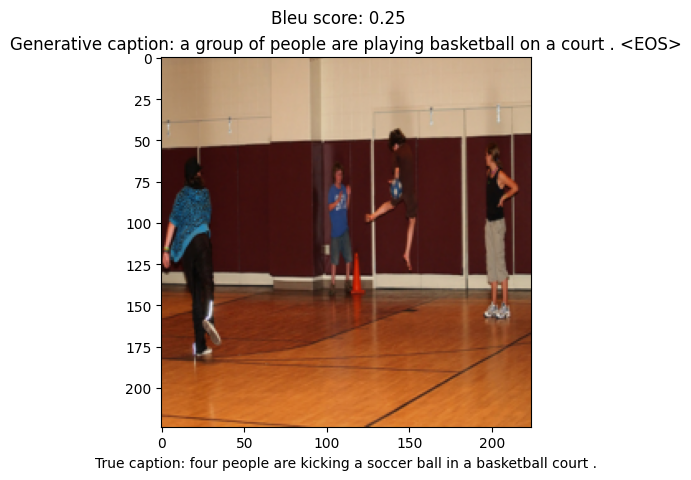

In [167]:
#show any 1
dataiter = iter(data_loader)
images,captions = next(dataiter)
cap = captions[0]
caption_label = [dataset.vocab.itos[token] for token in cap.tolist()]
eos_index = caption_label.index('<EOS>')
caption_label = caption_label[1:eos_index]
caption_label = ' '.join(caption_label)
img = images[0].detach().clone()
img1 = images[0].detach().clone()
caps = get_caps_from(img.unsqueeze(0),caption_label)

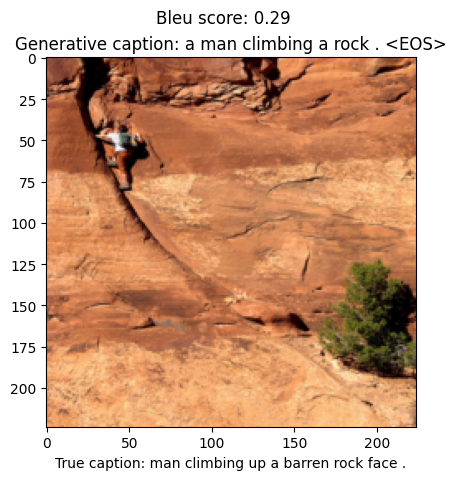

In [170]:
#show any 2
dataiter = iter(data_loader)
images,captions = next(dataiter)
cap = captions[0]
caption_label = [dataset.vocab.itos[token] for token in cap.tolist()]
eos_index = caption_label.index('<EOS>')
caption_label = caption_label[1:eos_index]
caption_label = ' '.join(caption_label)
img = images[0].detach().clone()
img1 = images[0].detach().clone()
caps = get_caps_from(img.unsqueeze(0),caption_label)

## 8) Visualizing the attentions
Defining helper functions
<li>Given the image generate captions and attention scores</li>
<li>Plot the attention scores in the image</li>

In [115]:
import matplotlib.pyplot as plt
from nltk.translate.bleu_score import sentence_bleu,SmoothingFunction

def get_caps_from(features_tensors,reference):
    # generate the caption
    model.eval()
    with torch.no_grad():
        features = model.encoder(features_tensors.to(device))
        caps, alphas = model.decoder.generate_caption(features, vocab=dataset.vocab)
        caption = ' '.join(caps)
        show_image(features_tensors[0], title="Generative caption: " +caption, bleu=get_bleu_score(caption, reference),reference="True caption: "+reference)
    return caps, alphas, caption

def get_bleu_score(candidate, reference):
    reference = reference.split()
    weights = (1,0,0,0)
    smoothing = SmoothingFunction().method4
    bleu_score = sentence_bleu(reference, candidate, weights=weights, smoothing_function=smoothing)
    return bleu_score

def plot_attention(img, result, attention_plot):
    # untransform
    img[0] = img[0] * 0.229
    img[1] = img[1] * 0.224
    img[2] = img[2] * 0.225
    img[0] += 0.485
    img[1] += 0.456
    img[2] += 0.406

    img = img.numpy().transpose((1, 2, 0))
    temp_image = img

    fig = plt.figure(figsize=(15, 15))
    len_result = len(result)
    for l in range(len_result):
        temp_att = attention_plot[l].reshape(7, 7)
        ax = fig.add_subplot(len_result // 2, len_result // 2, l + 1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.7, extent=img.get_extent())

    plt.tight_layout()
    plt.show()


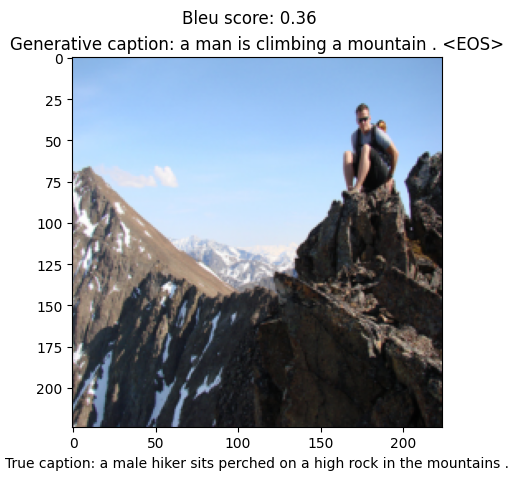

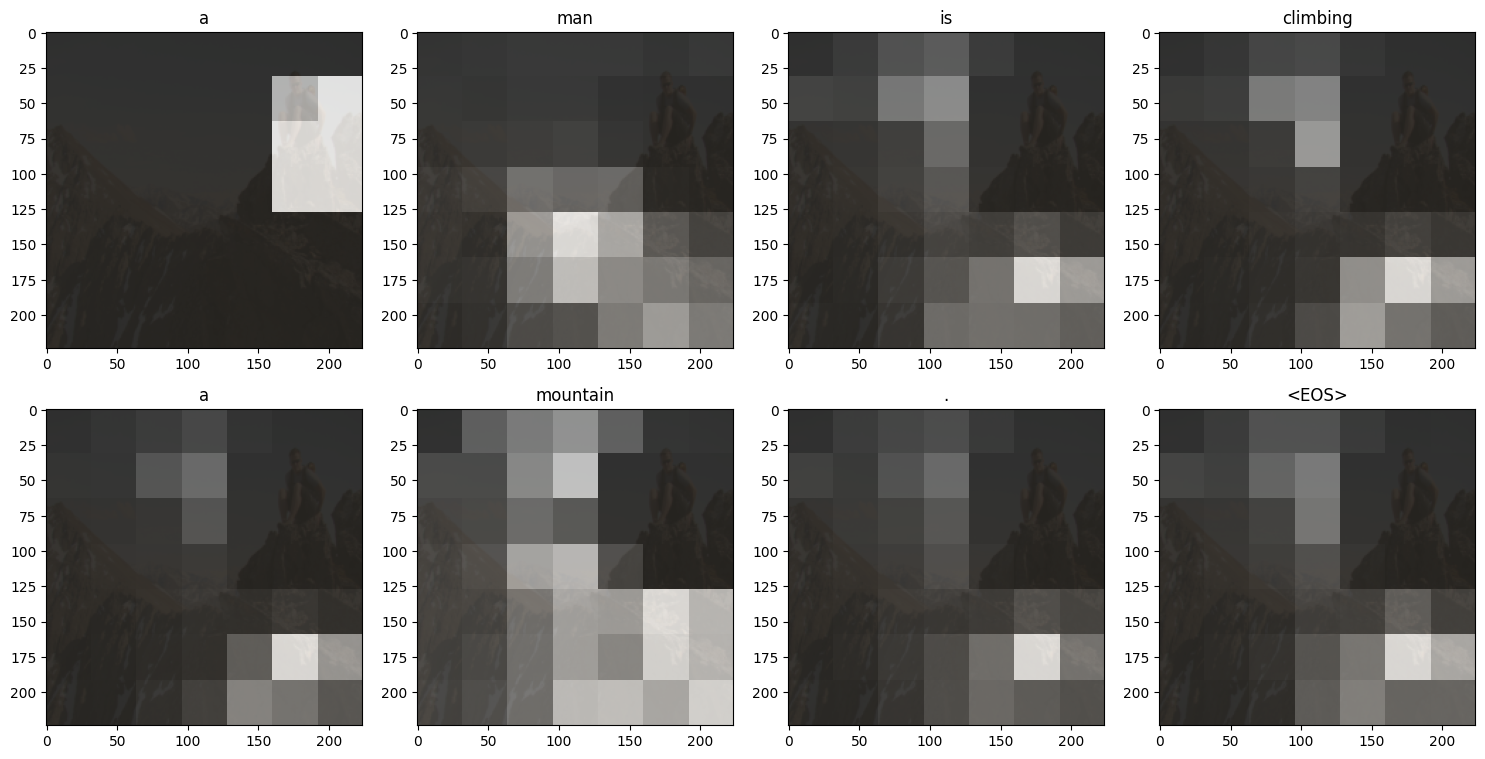

In [139]:
#show any 1
dataiter = iter(data_loader)
images,captions = next(dataiter)

img = images[0].detach().clone()
img1 = images[0].detach().clone()
cap = captions[0]
caption_label = [dataset.vocab.itos[token] for token in cap.tolist()]
eos_index = caption_label.index('<EOS>')
caption_label = caption_label[1:eos_index]
caption_label = ' '.join(caption_label)
caps,alphas,caption = get_caps_from(img.unsqueeze(0),caption_label)
plot_attention(img1, caps, alphas)

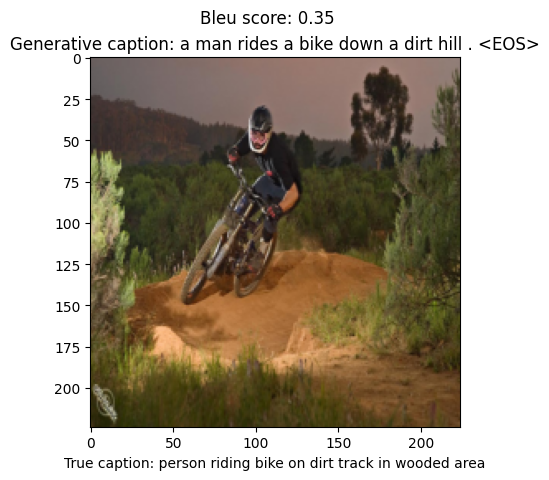

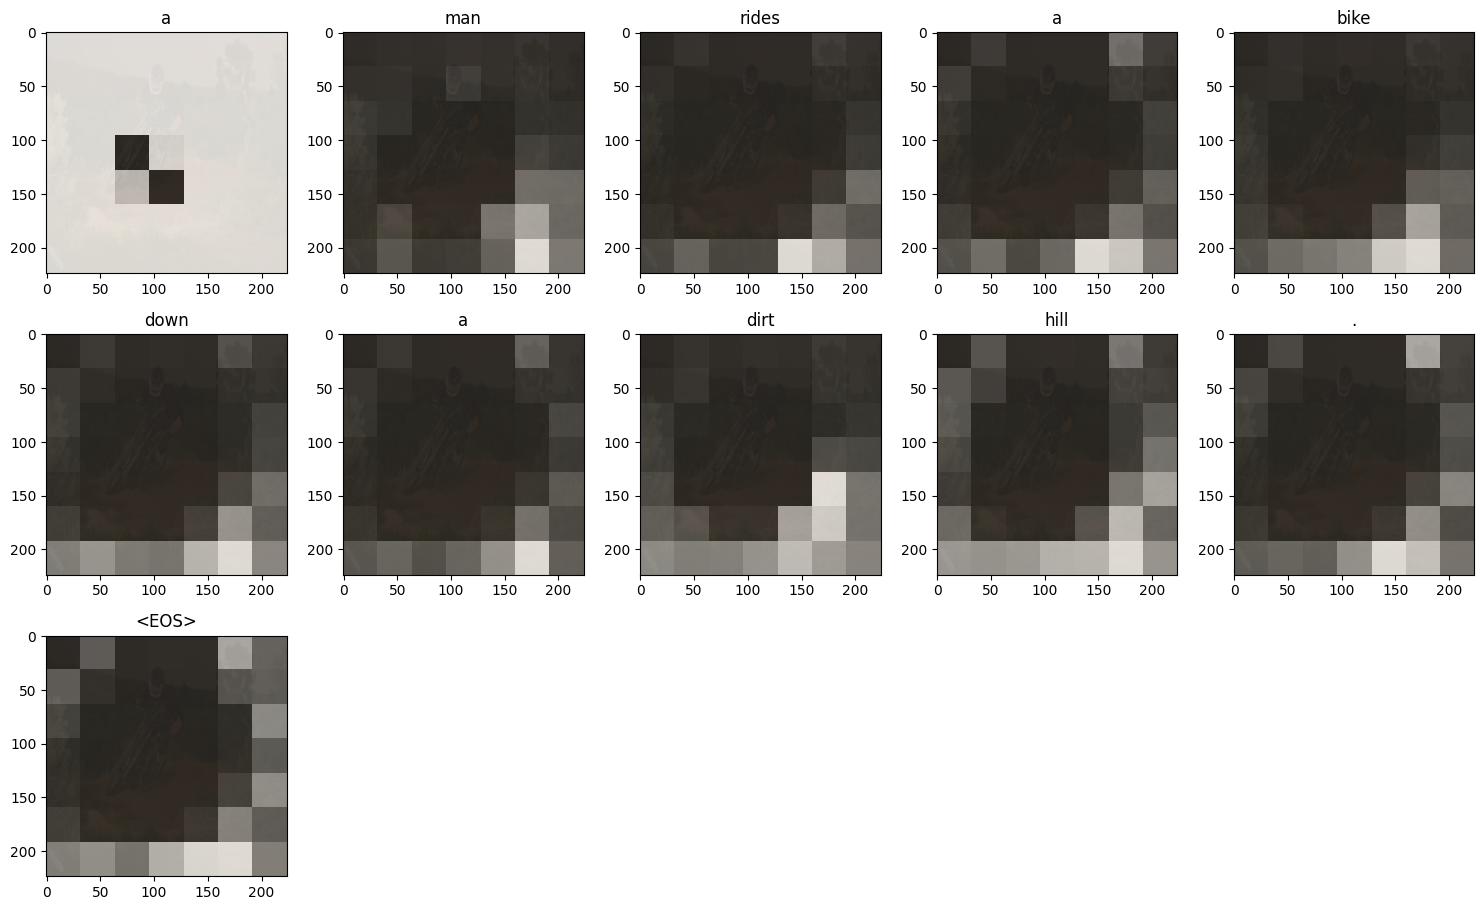

In [144]:
#show any 1
dataiter = iter(data_loader)
images,captions = next(dataiter)
img = images[0].detach().clone()
img1 = images[0].detach().clone()
cap = captions[0]
caption_label = [dataset.vocab.itos[token] for token in cap.tolist()]
eos_index = caption_label.index('<EOS>')
caption_label = caption_label[1:eos_index]
caption_label = ' '.join(caption_label)
caps,alphas,caption = get_caps_from(img.unsqueeze(0),caption_label)

plot_attention(img1, caps, alphas)

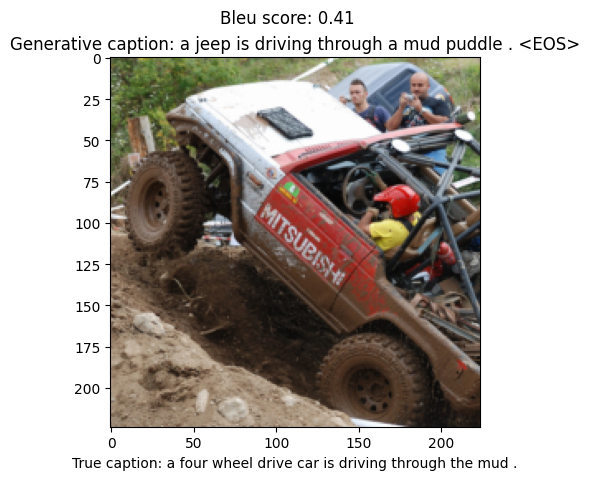

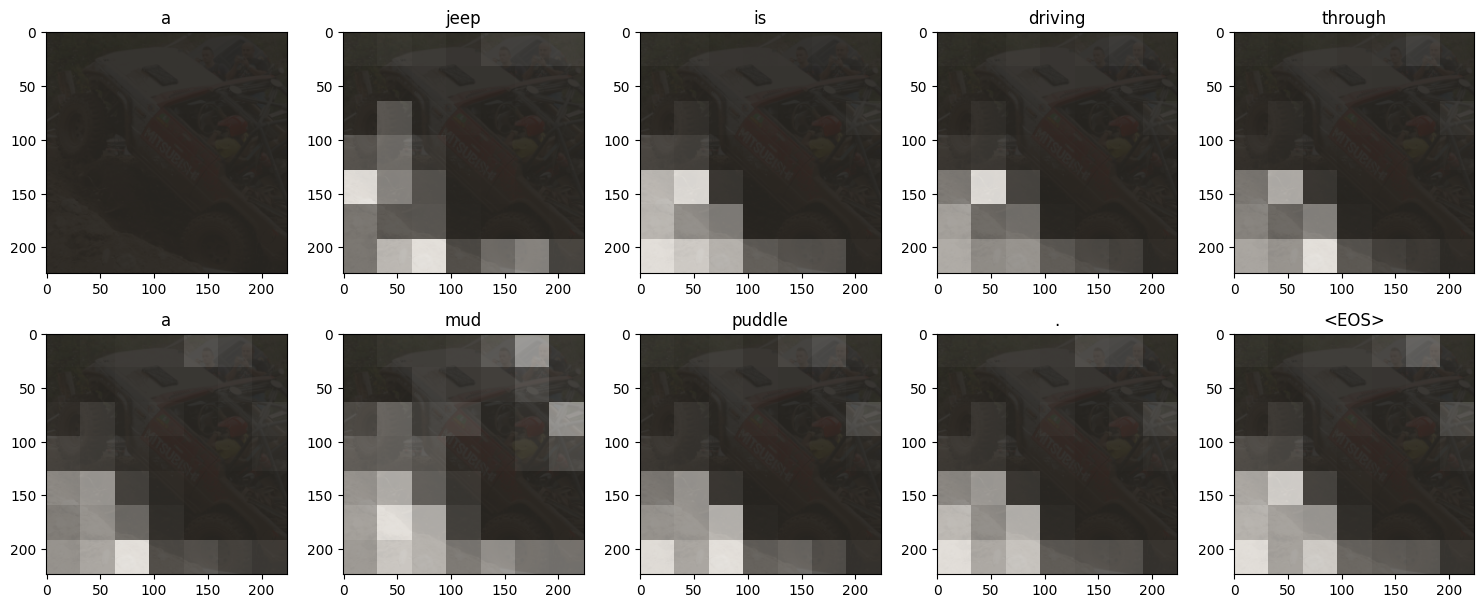

In [123]:
#show any 1
dataiter = iter(data_loader)
images,captions = next(dataiter)

img = images[0].detach().clone()
img1 = images[0].detach().clone()
cap = captions[0]
caption_label = [dataset.vocab.itos[token] for token in cap.tolist()]
eos_index = caption_label.index('<EOS>')
caption_label = caption_label[1:eos_index]
caption_label = ' '.join(caption_label)
caps,alphas,caption = get_caps_from(img.unsqueeze(0),caption_label)

plot_attention(img1, caps, alphas)